In [1]:
from cr_knee_fit import experiments
from cr_knee_fit.fit_data import Data, DataConfig

fit_data = Data.load(
    config=DataConfig(
        experiments_elements=[
            *experiments.DIRECT,
            experiments.grapes,
        ],
        experiments_all_particle=[
            # experiments.hawc,
        ],
    ),
    verbose=True,
)

Reading H data for Experiment(name='AMS-02', filename_stem='AMS-02')...
Reading He data for Experiment(name='AMS-02', filename_stem='AMS-02')...
Reading C data for Experiment(name='AMS-02', filename_stem='AMS-02')...
Reading O data for Experiment(name='AMS-02', filename_stem='AMS-02')...
Reading Mg data for Experiment(name='AMS-02', filename_stem='AMS-02')...
Reading Si data for Experiment(name='AMS-02', filename_stem='AMS-02')...
Reading Fe data for Experiment(name='AMS-02', filename_stem='AMS-02')...
Reading H data for Experiment(name='CALET', filename_stem='CALET')...
Reading He data for Experiment(name='CALET', filename_stem='CALET')...
Reading C data for Experiment(name='CALET', filename_stem='CALET')...
Reading O data for Experiment(name='CALET', filename_stem='CALET')...
Reading Mg data for Experiment(name='CALET', filename_stem='CALET')...
Failed to load Mg spectrum from Experiment(name='CALET', filename_stem='CALET'): /home/njvh/Documents/Science/cr-knee-fit/data/output/CALET_

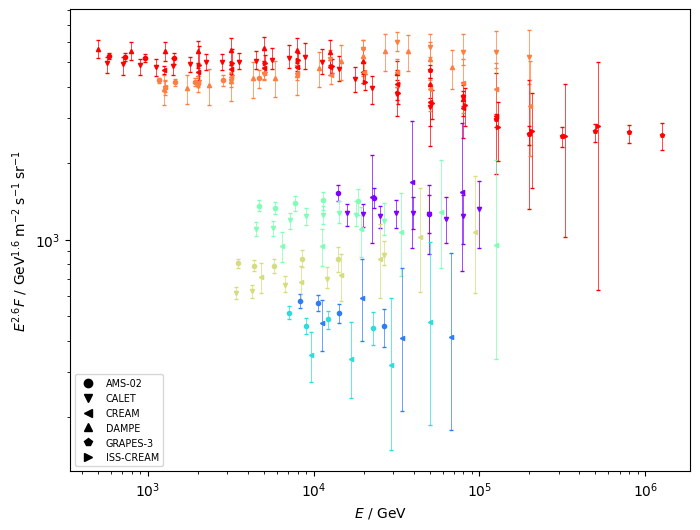

In [2]:
fit_data.plot(scale=2.6);

In [3]:
from bayesian_analysis import FitConfig, PlotsConfig, run_ml_analysis
from cr_knee_fit.cr_model import CosmicRaysModelConfig, SpectralBreakConfig
from cr_knee_fit.elements import Element
from cr_knee_fit.guesses import initial_guess_one_population_model
from cr_knee_fit.model_ import ModelConfig

bestfit, gof = run_ml_analysis(
    fit_data=fit_data,
    config=FitConfig.from_guessing_func(
        name="element-balance",
        fit_data=fit_data.config,
        mcmc=None,
        plots=PlotsConfig(),
        generate_guess=lambda: initial_guess_one_population_model(
            ModelConfig(
                cr_model_config=CosmicRaysModelConfig(
                    components=[[el] for el in Element.regular()],
                    breaks=[
                        SpectralBreakConfig(
                            fixed_lg_sharpness=0.7,
                            is_softening=True,
                            lg_break_prior_limits=(3.5, 4.5),
                        ),
                        SpectralBreakConfig(
                            fixed_lg_sharpness=0.7,
                            is_softening=False,
                            lg_break_prior_limits=(4.5, 5.5),
                        ),
                    ],
                ),
                shifted_experiments=fit_data.config.experiments_spectrum,
            )
        ),
    ),
    freeze_shifts=False,
)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 34.787695244814294
             x: [-4.097e+00  2.609e+00 ... -1.125e-02 -6.991e-03]
           nit: 7766
          nfev: 9748
 final_simplex: (array([[-4.097e+00,  2.609e+00, ..., -1.125e-02,
                        -6.991e-03],
                       [-4.097e+00,  2.609e+00, ..., -1.125e-02,
                        -6.991e-03],
                       ...,
                       [-4.097e+00,  2.609e+00, ..., -1.126e-02,
                        -6.990e-03],
                       [-4.097e+00,  2.609e+00, ..., -1.125e-02,
                        -6.991e-03]]), array([ 3.479e+01,  3.479e+01, ...,  3.479e+01,  3.479e+01]))
Goodness of fit: GoodnessOfFit(max_logpost=np.float64(-34.787695244814294), loglike_at_map=-52.697163333442816, ndim=24, aic=np.float64(117.57539048962859))


In [4]:
print(gof)

GoodnessOfFit(max_logpost=np.float64(-34.787695244814294), loglike_at_map=-52.697163333442816, ndim=24, aic=np.float64(117.57539048962859))


In [5]:
allparticle_data = Data.load(
    config=DataConfig(experiments_all_particle=[experiments.hawc, experiments.lhaaso_qgsjet])
)

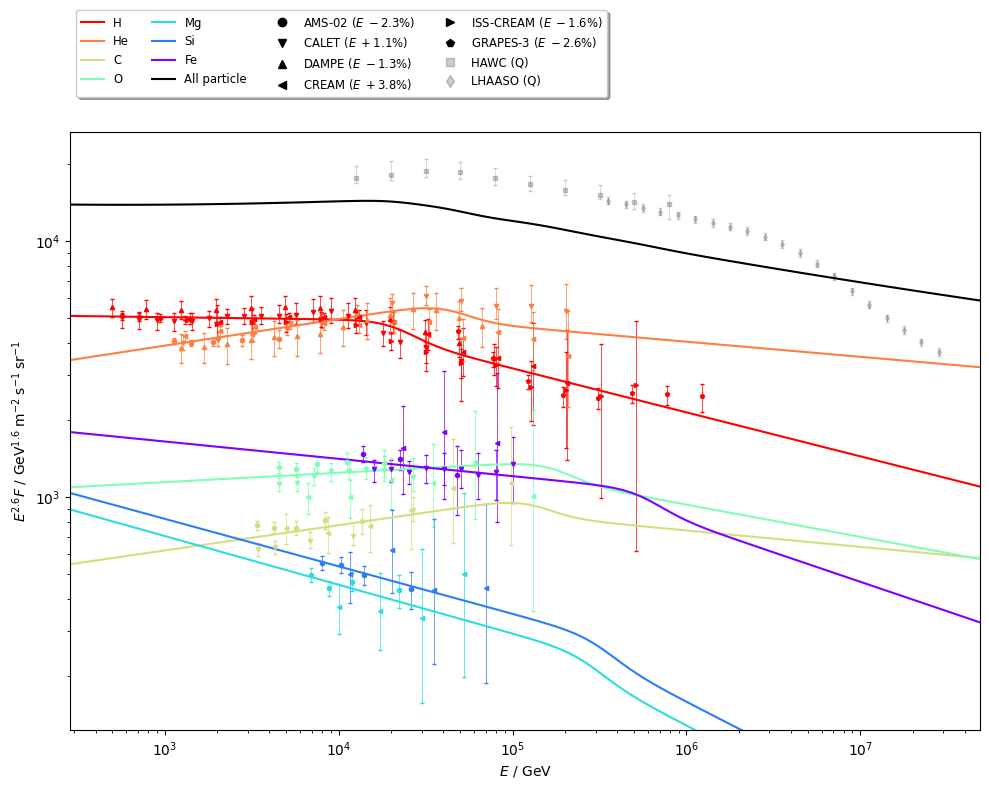

In [6]:
assert bestfit is not None
bestfit.plot_spectra(
    fit_data=fit_data,
    scale=2.6,
    validation_data=allparticle_data,
);

(3000.0, 280000.0)

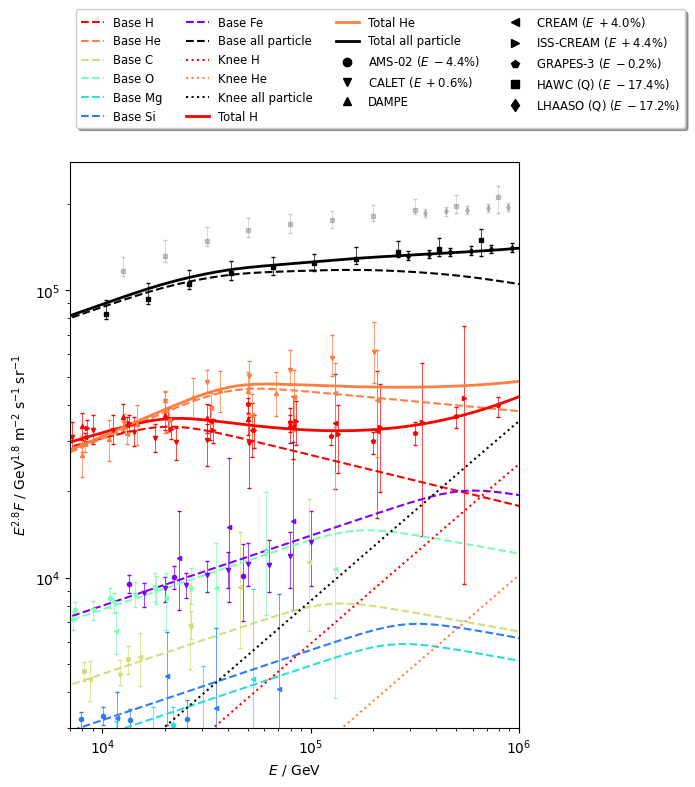

In [19]:
from pathlib import Path

from matplotlib import pyplot as plt

from cr_knee_fit.model_ import Model

fit_data = Data.load(
    config=DataConfig(
        experiments_elements=[
            *experiments.DIRECT,
            experiments.grapes,
        ],
        experiments_all_particle=[experiments.hawc, experiments.lhaaso_qgsjet],
    ),
)

scale = 2.8

twopop_dir = Path("out/2pop")
twopop_fit_config = FitConfig.model_validate_json((twopop_dir / "config-dump.json").read_text())
twopop_model_best = Model.load(twopop_dir / "posterior-ml.txt", layout_info=twopop_fit_config.model)
assert twopop_model_best is not None

fig, ax = plt.subplots(figsize=(6.5, 8))

fig = twopop_model_best.plot_spectra(fit_data=fit_data, scale=scale, axes=ax)

allparticle_data.plot_spectra(
    scale=scale,
    is_fitted=False,
    describe=False,
    ax=ax,
    legend=False,
)

ax.set_xlim(left=7e3, right=1e6)
ax.set_ylim(bottom=3e3, top=2.8e5)

In [20]:
hawc_allpart = allparticle_data.all_particle_spectra[experiments.hawc]

In [21]:
for E, F in zip(hawc_allpart.E, hawc_allpart.F):
    E_TeV = E / 1000
    if E_TeV > 100:
        continue
    ref = twopop_model_best
    # ref = bestfit
    pred = ref.compute_spectrum(E=E, element=None)
    ratio = F / pred
    print(E_TeV, ratio)

12.59 1.2265863709186593
19.95 1.2473072527563795
31.62 1.3037403153933484
50.12 1.3482154768024452
79.43 1.3705294014105207
